In [ ]:
!pip install trl -q # Ensure trl is installed
try:
    import trl
    print("trl is successfully installed and imported.")
except ModuleNotFoundError:
    print("trl is not installed or could not be imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 35.5 MB/s eta 0:00:00
trl is successfully installed and imported.


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from tqdm import tqdm

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorForLanguageModeling, # <--- FIX: NEW IMPORT
)
from peft import LoraConfig, PeftModel, get_peft_model
from datasets import Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from trl import SFTTrainer

In [ ]:
# ==========================================
# 1. CONFIGURATION & FILE PATHS
# ==========================================
TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
OUTPUT_DIR = "./phi3_stance_adapters"
PREDICTION_FILE = "test_predictions.csv"
MODEL_NAME = "microsoft/phi-3-mini-4k-instruct"
BATCH_SIZE = 4  # Use 8 for training, but WARNING: Reduce to 4 or 2 if memory crashes.

In [ ]:
# ==========================================
# 2. DATA PREPARATION (COHERENT WITH CoS)
# ==========================================


def prepare_data(df):
    """
    Formats the DataFrame rows for CoS fine-tuning by embedding the full 6-step logic.
    """
    # 1. Normalize stance
    df['Stance'] = df['Stance'].replace('NONE', 'NEUTRAL').str.upper()

    # 2. Create the final SFT text format including the full 6-step CoS instruction set
    df['text'] = df.apply(
        lambda row: (
            # --- START: FULL CHAIN OF STANCE INSTRUCTION (6 Steps from Paper) ---
            f"<|system|>You are a stance detection system trained on the Chain-of-Stance (CoS) methodology. Your goal is to determine the stance of the TWEET toward a given TARGET by executing the following reasoning pipeline internally:\n"
            f"Step 1: Understand the contextual information (identity, audience, socio-cultural background).\n"
            f"Step 2: Interpret the main ideas and core viewpoints in the TWEET (V).\n"
            f"Step 3: Analyze the language expression and emotional attitude (E).\n"
            f"Step 4: Compare the TWEET with all three possible stances (Favor, Against, Neutral) based on V and E.\n"
            f"Step 5: Conduct logical inference to confirm the consistency and rationality of the stance.\n"
            f"Step 6: Based on this entire process, determine the Final Stance polarity.\n"
            f"Respond ONLY with the Final Stance label (FAVOR, AGAINST, or NEUTRAL).<|end|>"
            # --- END: FULL CHAIN OF STANCE INSTRUCTION ---

            f"<|user|>TARGET: {row['Target']}\nTWEET: {row['Tweet']}<|end|>"
            f"<|assistant|>{row['Stance']}<|end|>" # Model is trained to output only the stance label here
        ), axis=1
    )
    return Dataset.from_pandas(df[['text']])

def load_and_preprocess_datasets():
    if not all([os.path.exists(TRAIN_FILE), os.path.exists(TEST_FILE)]):
        raise FileNotFoundError("Ensure train.csv and test.csv are available.")

    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)

    # Normalize test data for evaluation consistency
    test_df['Stance'] = test_df['Stance'].replace('NONE', 'NEUTRAL').str.upper()

    if os.path.exists(OUTPUT_DIR):
        print(f"Adapters found at {OUTPUT_DIR}. Skipping fine-tuning.")
        return None, test_df
    else:
        print("Preparing training data with full CoS instruction set...")
        train_dataset = prepare_data(train_df)
        print("Training data prepared.")
        return train_dataset, test_df


In [ ]:
# ==========================================
# 3. MODEL AND LORA SETUP (PURE 16-BIT)
# ==========================================

def setup_lora_model():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto",
        # trust_remote_code=True,  <--- REMOVED
        low_cpu_mem_usage=True
    )
    model.config.use_cache = False

    # LoRA Configuration (Based on Chain-of-Stance paper parameters)
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ],
        bias="none",
        task_type="CAUSAL_LM",
    )

    return model, tokenizer, lora_config


In [ ]:
# ==========================================
# 4. TRAINING AND SAVING
# ==========================================

def fine_tune(model, tokenizer, lora_config, train_dataset):
    print("\n--- Starting PURE LoRA Fine-Tuning (16-bit) ---")

    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=10,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=1,
        learning_rate=5e-5,
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=1,
        fp16=True,
        optim="adamw_torch",
        max_grad_norm=0.3,
        warmup_ratio=0.03,
        report_to="none"  # <--- FIX: DISABLE WANDB LOGGING
    )

    # FIX: Initialize Data Collator and pass it to trainer, removing 'tokenizer' argument.
    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        peft_config=lora_config,
        data_collator=data_collator, # <--- NEW ARGUMENT
        # tokenizer=tokenizer,       # <--- REMOVED ARGUMENT
       # max_seq_length=512, # <--- REMOVED: Argument moved/removed from SFTTrainer API
    )

    trainer.train()

    # Save the LoRA adapters
    trainer.model.save_pretrained(OUTPUT_DIR)
    print(f"\n✅ Fine-Tuning complete. Adapters saved to {OUTPUT_DIR}")


In [ ]:
# ==========================================
# 5. BATCH INFERENCE (TESTING)
# ==========================================

def run_batch_inference(model, tokenizer, test_df):
    print("\n--- Starting Batch Inference on Test Data ---")

    # We rebuild the CoS prompt but leave the assistant tag open
    test_prompts = test_df.apply(
        lambda row: (
            # --- START: FULL CHAIN OF STANCE INSTRUCTION (6 Steps from Paper) ---
            f"<|system|>You are a stance detection system trained on the Chain-of-Stance (CoS) methodology. Your goal is to determine the stance of the TWEET toward a given TARGET by executing the following reasoning pipeline internally:\n"
            f"Step 1: Understand the contextual information (identity, audience, socio-cultural background).\n"
            f"Step 2: Interpret the main ideas and core viewpoints in the TWEET (V).\n"
            f"Step 3: Analyze the language expression and emotional attitude (E).\n"
            f"Step 4: Compare the TWEET with all three possible stances (Favor, Against, Neutral) based on V and E.\n"
            f"Step 5: Conduct logical inference to confirm the consistency and rationality of the stance.\n"
            f"Step 6: Based on this entire process, determine the Final Stance polarity.\n"
            f"Respond ONLY with the Final Stance label (FAVOR, AGAINST, or NEUTRAL).<|end|>"
            # --- END: FULL CHAIN OF STANCE INSTRUCTION ---

            f"<|user|>TARGET: {row['Target']}\nTWEET: {row['Tweet']}<|end|>"
            f"<|assistant|>" # Model is expected to generate only the label here
        ), axis=1
    ).tolist()

    predictions = []
    INFERENCE_BATCH_SIZE = 8

    for i in tqdm(range(0, len(test_prompts), INFERENCE_BATCH_SIZE), desc="Batch Testing"):
        batch_prompts = test_prompts[i : i + INFERENCE_BATCH_SIZE]

        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        # Generate prediction
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10, # Max 10 tokens, expecting only FAVOR/AGAINST/NEUTRAL
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )

        input_len = inputs['input_ids'].shape[1]
        decoded_outputs = tokenizer.batch_decode(outputs[:, input_len:], skip_special_tokens=True)

        # Extract the single word prediction
        for output in decoded_outputs:
            predictions.append(output.strip())

    return predictions

def extract_label(text):
    """
    Extracts the first word as the stance label.
    """
    try:
        # Get the first word, as the model is trained to output ONLY the label
        stance = text.split()[0].strip().upper().replace('.', '')
        if stance in ['FAVOR', 'AGAINST', 'NEUTRAL']:
            return stance
        return "ERROR_PARSE"
    except Exception:
        return "ERROR_PARSE"


In [ ]:
# ==========================================
# 6. EVALUATION AND REPORTING
# ==========================================

def evaluate_and_report(test_df, predictions_raw):
    print("\n--- Generating Final Report ---")

    # Extract the final stance
    predictions_stance = [extract_label(p) for p in predictions_raw]

    # Store raw output for inspection (helpful if the model outputs more than one word)
    test_df['Raw_Prediction'] = predictions_raw

    # Ensure all labels are standardized (lowercase)
    norm_map = {'favour': 'favor', 'none': 'neutral', 'againt': 'against'}

    y_true = test_df['Stance'].astype(str).str.lower().str.strip().replace(norm_map)
    y_pred = pd.Series(predictions_stance).astype(str).str.lower().str.strip().replace(norm_map)

    # Standard labels for the report
    labels = ['favor', 'against', 'neutral']

    # Filter out potential invalid predictions
    valid_mask = y_pred.isin(labels)

    # Apply mask to both arrays
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]

    if len(y_true_valid) > 0:
        # Calculate metrics
        acc = accuracy_score(y_true_valid, y_pred_valid)
        f1_macro = f1_score(y_true_valid, y_pred_valid, average='macro', labels=labels)

        print("\n" + "="*40)
        print(f"Overall Accuracy: {acc:.2%}")
        print(f"Macro F1 Score:   {f1_macro:.4f}")
        print("="*40)

        # Classification Report
        print("\n--- Detailed Classification Report ---")
        print(classification_report(y_true_valid, y_pred_valid, labels=labels, zero_division=0))

        # Confusion Matrix Plot
        cm = confusion_matrix(y_true_valid, y_pred_valid, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[l.capitalize() for l in labels],
                    yticklabels=[l.capitalize() for l in labels])
        plt.title('Confusion Matrix (CoS Final Label Training)')
        plt.ylabel('Actual Stance')
        plt.xlabel('Predicted Stance')
        plt.savefig('confusion_matrix.png')
        print("[Image] Confusion matrix saved as 'confusion_matrix.png'")

        # Save predictions to CSV
        test_df['Predicted_Stance'] = y_pred
        test_df.to_csv(PREDICTION_FILE, index=False)
        print(f"Predictions saved to {PREDICTION_FILE}")
    else:
        print("No valid predictions were generated by the model.")


Adapters found at ./phi3_stance_adapters. Skipping fine-tuning.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Merged fine-tuned weights for inference.

--- Starting Batch Inference on Test Data ---


Batch Testing: 100%|██████████| 151/151 [01:35<00:00,  1.58it/s]



--- Generating Final Report ---

Overall Accuracy: 75.46%
Macro F1 Score:   0.7318

--- Detailed Classification Report ---
              precision    recall  f1-score   support

       favor       0.70      0.80      0.75       304
     against       0.88      0.73      0.79       708
     neutral       0.56      0.78      0.65       194

    accuracy                           0.75      1206
   macro avg       0.71      0.77      0.73      1206
weighted avg       0.78      0.75      0.76      1206

[Image] Confusion matrix saved as 'confusion_matrix.png'
Predictions saved to test_predictions.csv


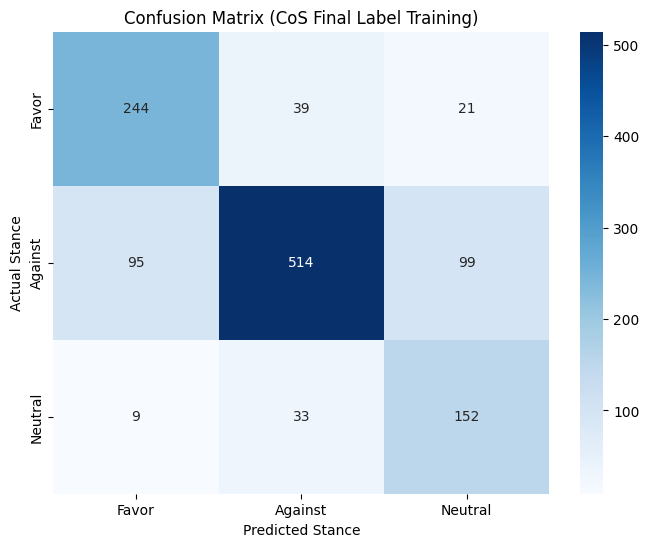

In [ ]:
# ==========================================
# 7. MAIN EXECUTION FLOW
# ==========================================

if __name__ == "__main__":
    try:
        # 1. Load/Prepare Data
        train_dataset, test_df = load_and_preprocess_datasets()

        # 2. Setup Model
        model, tokenizer, lora_config = setup_lora_model()

        # 3. Fine-Tune (Only if adapters don't exist)
        if train_dataset:
            fine_tune(model, tokenizer, lora_config, train_dataset)

        # 4. Load/Merge Adapter Weights for Inference
        try:
            best_checkpoint = OUTPUT_DIR
            model = PeftModel.from_pretrained(model, best_checkpoint)
            model = model.merge_and_unload()
            print("\n✅ Merged fine-tuned weights for inference.")
        except Exception as e:
            print(f"Warning: Could not merge adapters. Running inference on base model only. Error: {e}")

        # 5. Run Batch Inference
        predictions_raw = run_batch_inference(model, tokenizer, test_df)

        # 6. Evaluate and Report
        evaluate_and_report(test_df, predictions_raw)

    except FileNotFoundError as e:
        print(f"File Error: {e}. Please ensure 'train.csv' and 'test.csv' are in the same directory.")
    except Exception as e:
        print(f"Critical Error during execution: {e}")

In [ ]:
import os
from google.colab import files
import shutil

# --- Configuration ---
# Use the absolute path provided by the user
ADAPTER_FOLDER_PATH = "/content/phi3_stance_adapters"
ZIP_FILENAME = "phi3_stance_adapters_backup.zip"
PARENT_DIR = "/content" # The directory containing the folder

print(f"Attempting to zip and download folder: '{ADAPTER_FOLDER_PATH}'")

# Check if the adapter folder exists
if os.path.isdir(ADAPTER_FOLDER_PATH):
    print("Folder found. Creating clean zip archive...")

    # 1. Change directory to the parent folder to run the zip command cleanly
    %cd {PARENT_DIR}

    # 2. Create the zip file using a robust command.
    # -r: Recursive (includes all contents)
    # -q: Quiet
    # We specify the folder name relative to the current directory (/content)
    try:
        # Note: We are zipping the folder itself (phi3_stance_adapters) into the zip file.
        !zip -r -q {ZIP_FILENAME} {ADAPTER_FOLDER_PATH.split('/')[-1]}
        print(f"Successfully created archive: {ZIP_FILENAME}")

        # 3. Verify existence before downloading
        if os.path.exists(ZIP_FILENAME):
            print("Zip file confirmed to exist locally. Initiating download...")

            # 4. Download the single zip file
            files.download(ZIP_FILENAME)

            print(f"\n✅ Download initiated for '{ZIP_FILENAME}'.")

            # 5. Clean up the zip file after download
            os.remove(ZIP_FILENAME)
            print(f"Cleaned up local zip file.")
        else:
            print(f"❌ ERROR: Zip file '{ZIP_FILENAME}' was not created despite previous message.")

    except Exception as e:
        print(f"\n❌ A critical error occurred during zipping or downloading: {e}")

else:
    print(f"\n❌ ERROR: Adapter folder '{ADAPTER_FOLDER_PATH}' was not found.")
    print("Please ensure the fine-tuning script completed successfully and created the folder.")

Attempting to zip and download folder: '/content/phi3_stance_adapters'
Folder found. Creating clean zip archive...
/content
Successfully created archive: phi3_stance_adapters_backup.zip
Zip file confirmed to exist locally. Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download initiated for 'phi3_stance_adapters_backup.zip'.
Cleaned up local zip file.
